In [3]:
import pickle

# Specify the path to your pickle file
pickle_file = "processed_voxel_data.local/all_datasets_voxel_data.pkl"

# Load the data
with open(pickle_file, "rb") as f:
    data = pickle.load(f)

# Check the structure of the data
print("Metadata:", data['metadata'])
print("Number of voxel entries:", len(data['voxel_data']))

# Optionally, convert voxel data to a DataFrame for easier inspection
import pandas as pd

voxel_df = pd.DataFrame(data['voxel_data'])
voxel_df.head()


Metadata: {'voxel_size': 1, 'min_num_points': 20, 'min_proportion': 0.8, 'datasets': ['flight', 'siegertsbrunn', 'garching', 'aying_hills', 'aying_mangfall', 'garching_2', 'neubiberg_rain', 'neubiberg_sunny']}
Number of voxel entries: 1237869


,dataset,voxel_key,center_x,center_y,num_points,dominant_label,dominant_proportion,RMSE,plane_coefficients,vertical_skewness,convex_hull_volume,density,elevation_range
0,flight,"(-2, -1)",-1.5,-0.5,195,8,1.000000,0.056544,"[-0.5379800133475481, -0.076032829749107, 0.83...",1.040636,0.014004,13924.378843,0.213960
1,flight,"(-7, -1)",-6.5,-0.5,41,23,1.000000,0.001638,"[-0.2587742154996574, -0.020896474074129392, 0...",-0.099635,0.000138,297484.438643,0.018769
2,flight,"(-9, -1)",-8.5,-0.5,31,23,1.000000,0.000978,"[-0.20376935366423798, -0.015933593684945773, ...",0.195150,0.000041,751355.836403,0.015475
3,flight,"(-12, -2)",-11.5,-1.5,23,23,0.913043,0.000635,"[-0.1917638524069574, -0.023974262892946574, 0...",-0.340627,0.000038,604360.263462,0.011396
4,flight,"(-14, -2)",-13.5,-1.5,20,23,1.000000,0.000501,"[-0.1782574389317535, -0.01940379690967842, 0....",1.651364,0.000042,481791.740871,0.017959


In [5]:
voxel_df.keys()

Index(['dataset', 'voxel_key', 'center_x', 'center_y', 'num_points',
       'dominant_label', 'dominant_proportion', 'RMSE', 'plane_coefficients',
       'vertical_skewness', 'convex_hull_volume', 'density',
       'elevation_range'],
      dtype='object')

In [6]:
# Display unique values and their counts in the 'dominant_label' column
dominant_values_counts = voxel_df['dominant_label'].value_counts()
print(dominant_values_counts)


dominant_label
16          276839
50          247142
51          121462
27           86603
23           81528
             ...  
15925294         1
20578340         1
11993094         1
24838150         1
5505030          1
Name: count, Length: 2575, dtype: int64


In [7]:
import import_helper as ih

# Load metadata and create a map of label_key to label_name
metadata_map = ih.get_metadata_map(ih.load_label_metadata())

# Count occurrences of each dominant label
label_counts = voxel_df['dominant_label'].value_counts()

# Map label keys to names and create a dictionary of label names and their counts
label_name_counts = {ih.get_label_name(label, metadata_map): count for label, count in label_counts.items()}

# Display the results
for label_name, count in label_name_counts.items():
    print(f"{label_name}: {count}")


INFO: Label metadata loaded successfully
INFO: Metadata map successfully created.


forest: 276839
low_grass: 247142
high_grass: 121462
tree_crown: 86603
asphalt: 81528
bush: 67229
hedge: 61299
snow: 57840
building: 52881
soil: 35002
gravel: 31170
crops: 20522
fence: 10631
sidewalk: 9745
obstacle: 4087
cobble: 3014
ego_vehicle: 1869
bridge: 1588
wall: 1489
leaves: 1440
debris: 1252
curb: 551
guard_rail: 526
undefined: 492
None: 1
rail_track: 75
road_marking: 55
moss: 32
water: 28
wire: 24
bikeway: 17
pipe: 4
barrier_tape: 3


In [16]:
import import_helper as ih
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load metadata and create a map of label_key to label_name
metadata_map = ih.get_metadata_map(ih.load_label_metadata())

# Count occurrences of each dominant label
label_counts = voxel_df['dominant_label'].value_counts()

# Map label keys to names and create a dictionary of label names and their counts
label_name_counts = {ih.get_label_name(label, metadata_map): count for label, count in label_counts.items()}

# Convert to DataFrame
label_counts_df = pd.DataFrame(list(label_name_counts.items()), columns=['Label', 'Count'])

# Print to verify the structure
print(label_counts_df.head())


INFO: Label metadata loaded successfully
INFO: Metadata map successfully created.


        Label   Count
0      forest  276839
1   low_grass  247142
2  high_grass  121462
3  tree_crown   86603
4     asphalt   81528


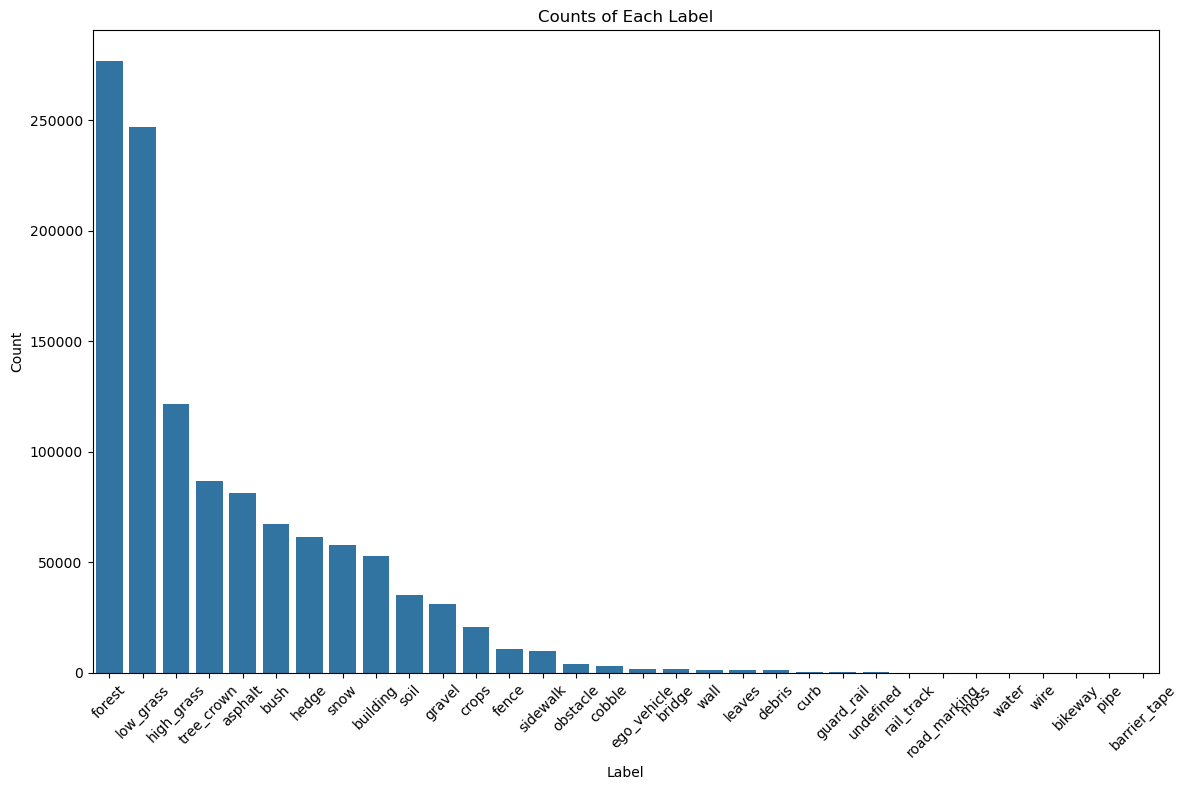

In [17]:
plt.figure(figsize=(12, 8))
sns.barplot(data=label_counts_df, x='Label', y='Count')
plt.xticks(rotation=45)
plt.title("Counts of Each Label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


INFO: Label metadata loaded successfully
INFO: Metadata map successfully created.


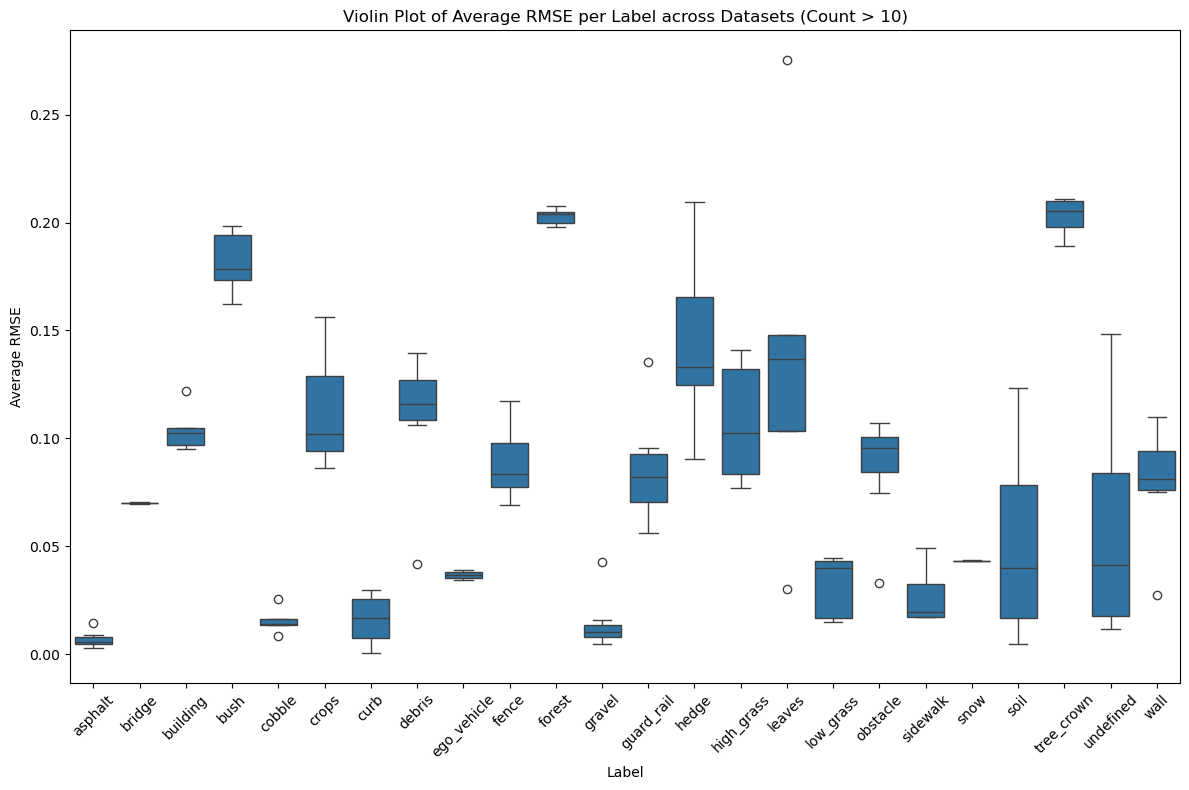

In [11]:
import import_helper as ih
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load metadata and create a map of label_key to label_name
metadata_map = ih.get_metadata_map(ih.load_label_metadata())

# Add label names based on dominant_label
voxel_df['dominant_label_name'] = voxel_df['dominant_label'].apply(lambda x: ih.get_label_name(x, metadata_map))

# Calculate counts of each label
label_counts = voxel_df['dominant_label_name'].value_counts()

# Filter for labels with count > 10
labels_with_sufficient_data = label_counts[label_counts > 100].index
filtered_df = voxel_df[voxel_df['dominant_label_name'].isin(labels_with_sufficient_data)]

# Calculate average RMSE per label per dataset
average_rmse_df = filtered_df.groupby(['dominant_label_name', 'dataset'])['RMSE'].mean().reset_index()

# Plot the violin plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=average_rmse_df, x='dominant_label_name', y='RMSE')
plt.xticks(rotation=45)
plt.title("Violin Plot of Average RMSE per Label across Datasets (Count > 10)")
plt.xlabel("Label")
plt.ylabel("Average RMSE")
plt.tight_layout()
plt.show()


INFO: Label metadata loaded successfully
INFO: Metadata map successfully created.


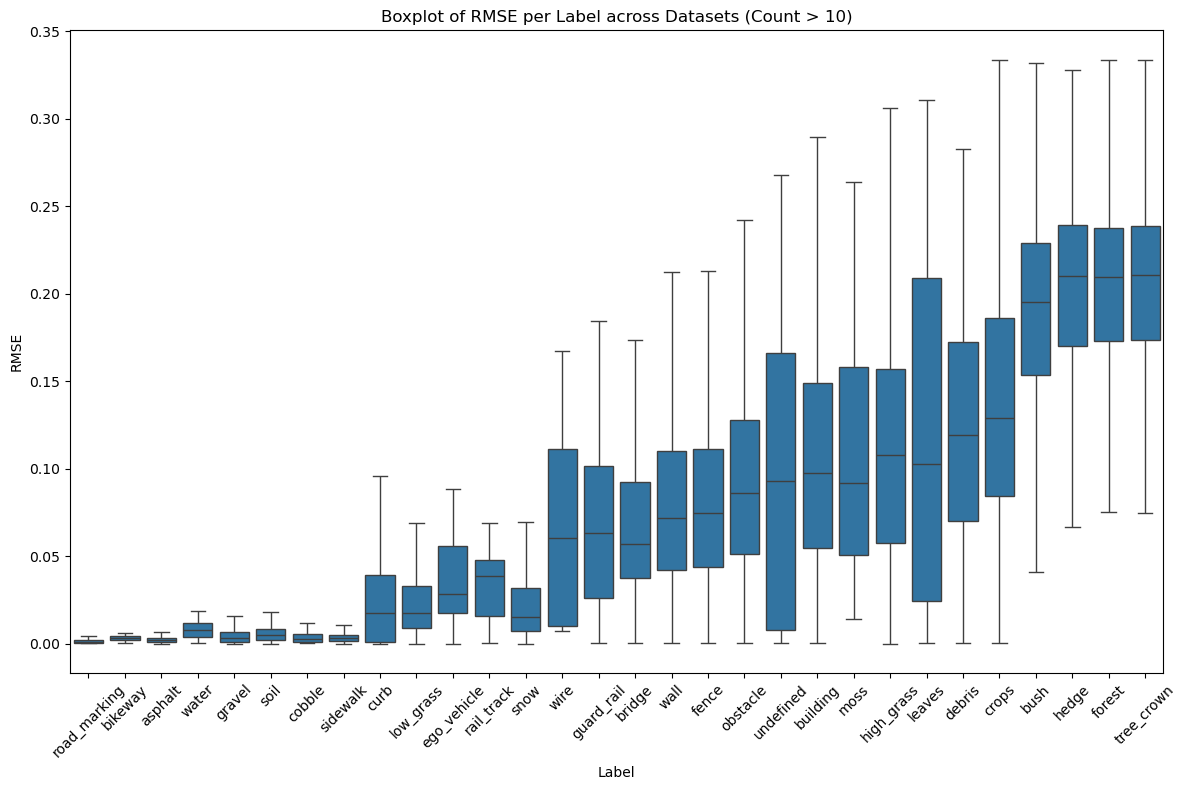

In [14]:
import import_helper as ih
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load metadata and create a map of label_key to label_name
metadata_map = ih.get_metadata_map(ih.load_label_metadata())

# Add label names based on dominant_label
voxel_df['dominant_label_name'] = voxel_df['dominant_label'].apply(lambda x: ih.get_label_name(x, metadata_map))

# Calculate counts of each label
label_counts = voxel_df['dominant_label_name'].value_counts()

# Filter for labels with count > 10
labels_with_sufficient_data = label_counts[label_counts > 10].index
filtered_df = voxel_df[voxel_df['dominant_label_name'].isin(labels_with_sufficient_data)]

# Calculate average RMSE per label for ordering
label_order = (
    filtered_df.groupby('dominant_label_name')['RMSE']
    .mean()
    .sort_values()
    .index
)

# Plot the ordered boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=filtered_df, x='dominant_label_name', y='RMSE', order=label_order, showfliers=False )
plt.xticks(rotation=45)
plt.title("Boxplot of RMSE per Label across Datasets (Count > 10)")
plt.xlabel("Label")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()


INFO: Label metadata loaded successfully
INFO: Metadata map successfully created.


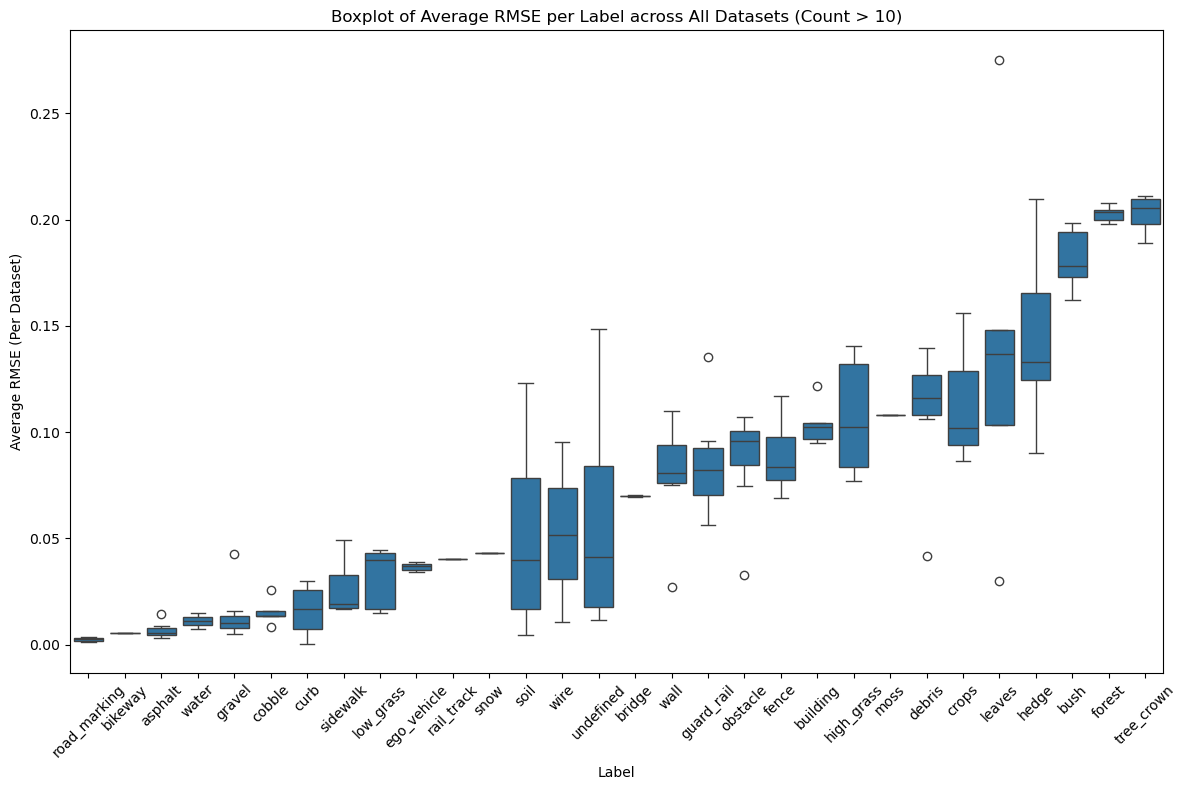

In [13]:
import import_helper as ih
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load metadata and create a map of label_key to label_name
metadata_map = ih.get_metadata_map(ih.load_label_metadata())

# Add label names based on dominant_label
voxel_df['dominant_label_name'] = voxel_df['dominant_label'].apply(lambda x: ih.get_label_name(x, metadata_map))

# Calculate counts of each label
label_counts = voxel_df['dominant_label_name'].value_counts()

# Filter for labels with count > 10
labels_with_sufficient_data = label_counts[label_counts > 10].index
filtered_df = voxel_df[voxel_df['dominant_label_name'].isin(labels_with_sufficient_data)]

# Calculate the average RMSE per label per dataset
average_rmse_per_label_dataset = (
    filtered_df.groupby(['dominant_label_name', 'dataset'])['RMSE']
    .mean()
    .reset_index()
)

# Order labels by their overall average RMSE for better visual clarity
label_order = (
    average_rmse_per_label_dataset.groupby('dominant_label_name')['RMSE']
    .mean()
    .sort_values()
    .index
)

# Plot the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=average_rmse_per_label_dataset, x='dominant_label_name', y='RMSE', order=label_order)
plt.xticks(rotation=45)
plt.title("Boxplot of Average RMSE per Label across All Datasets (Count > 10)")
plt.xlabel("Label")
plt.ylabel("Average RMSE (Per Dataset)")
plt.tight_layout()
plt.show()
